## 1. Importing Libraries

In [1]:
#wandb for tracking multiple runs
#torchmetrics for GAN evaluation using FID and IS Score
!pip install wandb torchmetrics[image]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=ddd780de4b71e32d67d39b4129b12f833645fec0267087d60a7c7ae70d80de34
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Atte

In [36]:
#Install torchvision
pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#to allow duplicate libraries
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
#Checking the GPU availability
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
#Check CPU and GPU which is from colab P-100
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17748310258726278241
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14417788928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9407241153536496031
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [7]:
#Importing most of the main libraries used here
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils import data
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable
from typing import Tuple, Optional, Union, Dict, Sequence
from functools import partial
from torchvision.utils import save_image
from tqdm import tqdm
import torch.nn.functional as F

In [6]:
# install wandb to login later
%pip install wandb -q

In [8]:
#Import wandb and login
import wandb
wandb.login()
wandb.init(project="DEEL-CA2-GAN") #Change project name if needed

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # for new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: raymondng009. Use `wandb login --relogin` to force relogin


Random Seed:  999


API Login Key for Wandb
7807b65cfd69b4131fd5347c75e9e6fd783eb5d8

In [9]:
#Environment setup
from torch import cuda, optim
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

#Set device for computation purposes
device = torch.device("cuda:0" if train_on_gpu else "cpu")

#Find the number of GPUS
multi_gpu = False
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


## 2. Data Preprocessing

In [10]:
#Calculate mean and std here with train_data 
train_data = dataset.CIFAR10('./data', train=True, download=True)

# Stick all the images together 
x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])

# calculate the mean and std along the (0, 1) axes
data_mean = np.mean(x, axis=(0, 1))/255
data_std = np.std(x, axis=(0, 1))/255
# the the mean and std of dataset
data_mean=data_mean.tolist()
data_std=data_std.tolist()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [11]:
#Print mean and std of cifar-10
print(data_mean)
print(data_std)

[0.49139967861519607, 0.48215840839460783, 0.44653091444546567]
[0.24703223246174102, 0.24348512800151828, 0.26158784172803257]


In [12]:
#Set mean and std values of CIFAR-10 

#Calculated values from above
data_mean = (0.491, 0.482, 0.446)
data_std = (0.247, 0.243, 0.261)

#Normalizing with 0.5 values as recommended in technical paper
normalize_mean_std = (0.5, 0.5, 0.5)

#transform
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean_std, normalize_mean_std)
])

#Download both train and test data with preprocessing of normalize and to tensor
#From torchvision.data
train_data = dataset.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_data = dataset.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

#Concatenate the dataset since its a GAN
dataConcat = data.ConcatDataset((train_data, test_data))

Files already downloaded and verified
Files already downloaded and verified


In [13]:
#Inverse normalize to view images after being produced
import torchvision.transforms.functional as F
def inverseNormalize(imgs: torch.Tensor, mean=data_mean, std=data_std):
    mean = torch.as_tensor(mean)
    std = torch.as_tensor(std)
    std_inv = 1 / (std + 1e-7)
    mean_inv = -mean * std_inv

    return F.normalize(imgs, mean=mean_inv, std=std_inv)

In [ ]:
#Add label smoothing only for CGANS
def label_smoothing(labels, factor):
  #This is to smooth the labels
  labels = torch.as_tensor(labels)
  factor = torch.as_tensor(factor)
  # labels = labels.long()
  # factor = factor.long()
  labels *= (1-factor)
  labels += (factor/labels.shape[1])

  return labels

In [14]:
#Concatenated the trg and test datasets
concat_data:data.Dataset = dataConcat
data_loader = data.DataLoader(
    concat_data,
    batch_size=128,
    shuffle=True
)
cifar10_classnames=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [15]:
#Basic EDA with labels for train_data
demo_loader = torch.utils.data.DataLoader(train_data, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 3, 32, 32]) torch.Size([10])


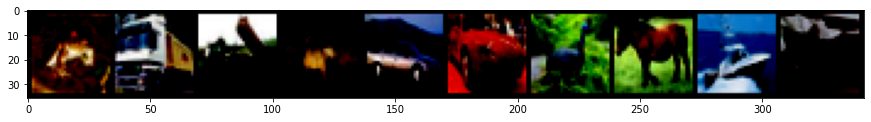

In [16]:
#Showing some basic images
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

## 3. Helper Functions 
These functions helped make the training process easier in shorter lines of code
inspired from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

Several other helper Functions are also inspired from https://github.com/kiritowu/Deep-Learning/blob/main/GAN/AC-BIGGAN-with-CIFAR10/notebook-archieve/acgan/acgan.ipynb

In [17]:
#Returns list of classname based on label tensor
def return_classname(labels: torch.Tensor, classname_mapping: Sequence[str])->Sequence[str]:
    return list(map(lambda l: classname_mapping[l], labels))

In [18]:
#Generate plot of image batch 
def plot(epoch, imgs, labels, inv_preprocessing, print, grid_row=10, figsize=(10,10), save_path=None):

    #calling Inverse processing
    if inv_preprocessing is not None:
        for inv in inv_preprocessing:
            imgs = inv(imgs)

    #Plot the figure
    fig = plt.figure(figsize=figsize, tight_layout=True)
    for i in range(grid_row * grid_row):
        ax = fig.add_subplot(grid_row, grid_row, i + 1)
        ax.imshow(F.to_pil_image(imgs[i]))
        ax.set_title("{}".format(labels[i] if labels else ""))
        ax.axis("off")

    #Save figure into colab files
    if save_path:
        plt.savefig(f"{save_path}/generated_img_{epoch}.png")

    #log the images in wandb
    wandb.log({"generated_images":wandb.Image(imgs), "epoch":epoch})
    
    if print:
      #Plot the graph out
      plt.show()

In [19]:
#Save generator image batches
#Generator will generate fake images in batches and this function will save those images in batches
def save_gen_imgs(epoch, base_folder, generator, image_num, n_classes, latent_dim, classname_mapping, device, inv_preprocessing):

    #Calculate batch size the 
    batch_size = image_num//n_classes
    n_batch = image_num//batch_size
    #Make latent_space of noise
    latent_space = torch.normal(0, 1, (n_batch, batch_size, latent_dim), device=device, requires_grad=False)

    #Generate grids to show multiple images at once
    gen_grids = torch.arange(0, n_classes, device=device)\
                    .tile(100)\
                    .reshape(batch_size, n_batch)\
                    .T

    #Randomly shuffle labels

    # Making Random Indices
    perm_indices = torch.randperm(batch_size*n_batch)
    # Doing Indices Mapping
    random_map = {idx: int(random_idx) for idx, random_idx in enumerate(perm_indices)}
    reverse_map = {v:k for k,v in random_map.items()}
    # Generating the Indices List for Mapping
    to_random = list(random_map.values())
    to_ordered = list({reverse_key: reverse_map[reverse_key] for reverse_key in sorted(reverse_map)}.values())
    # Randomizing the Label
    gen_labels = gen_grids.reshape(-1)[to_random].reshape(n_batch, batch_size)

    #Appending the generated images in an array
    gen_imgs = []
    with torch.no_grad():
        for latent_batch, gen_batch in zip(latent_space, gen_labels):
            gen_img = generator(latent_batch, gen_batch)
            gen_imgs.append(gen_img.cpu())
            
    #Return the generated labels for those images
    gen_imgs_torch = torch.stack(gen_imgs).reshape(-1, 3, 32, 32).cpu()
    gen_labels = np.array(return_classname(gen_labels.reshape(-1).cpu(), classname_mapping))

    # Order the randomized images and labels
    gen_imgs_torch_sorted = gen_imgs_torch[to_ordered]
    gen_labels_sorted = gen_labels[to_ordered]

    #Make sure to save each classname, 100 pics of each to generate total 1000
    for folder_dir in [base_folder, f"{base_folder}/{epoch}", 
                        *[f"{base_folder}/{epoch}/{classname}" for classname in classname_mapping]]:
        if not os.path.exists(folder_dir):
            os.makedirs(folder_dir)
    
    #Inverse processing for seeing the images
    if inv_preprocessing is not None:
        gen_imgs_torch_sorted = inv_preprocessing(gen_imgs_torch_sorted)

    #Save the images into the folder
    for idx, (img, label) in enumerate(zip(gen_imgs_torch_sorted, gen_labels_sorted)):
        F.to_pil_image(img).save(f"{base_folder}/{epoch}/{label}/{idx}.png")

In [20]:
#Function to create noise tensor
#Generator needs a random noise tensor to create fake images

def create_noise(sample_size, nz):#sample size should be fixed to 64 defined later, nz is dimension of noise vector which is 100 dimensional
    return torch.randn(sample_size, nz, 1, 1).to(device)

#Print size of noisne vector [128 or 32, 100, 1, 1]

In [21]:
#Creating fake and real labels

#Function to create real labels (1)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

#Function to create fake labels (0)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

#Example if its real => 1
#if its fake => 0
#Since batch size is 64 output for real images will be [1,1,1,1,...] 64 times

In [22]:
import torch
import torch.nn as nn

#initializing the weights of the models
def weights_init(m):
    if (isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear)):
        nn.init.orthogonal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.)
    elif isinstance(m, nn.Embedding):
        nn.init.orthogonal_(m.weight)
    else:
        pass

## 4. Visualizations

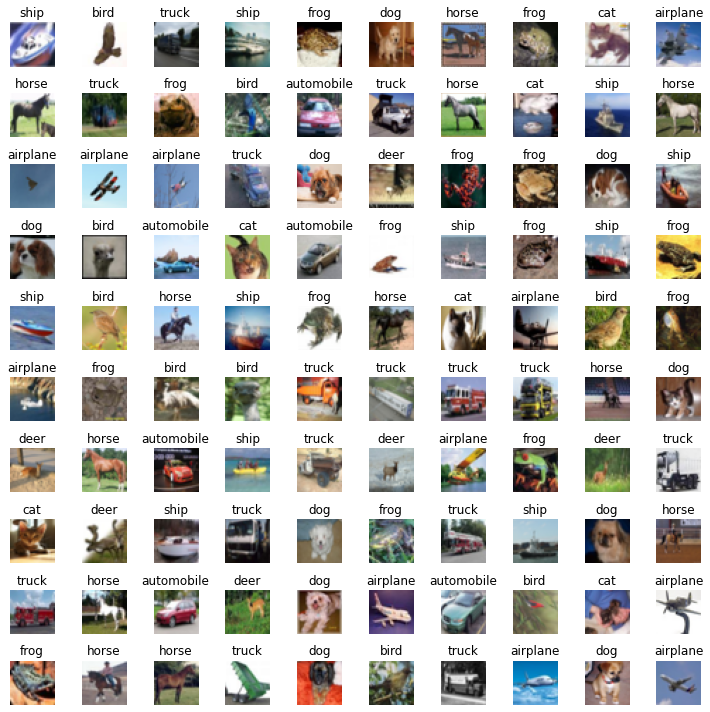

In [23]:
#Between -1 and 1 for normalization similar to generator output 'tanh' range -1 to 1
img_batch, labels_batch = next(iter(data_loader))
assert torch.max(img_batch).cpu().item() == 1.0
assert torch.min(img_batch).cpu().item() == -1.0

#Plot grid of images with epoch of 0 since this is a test
plot(epoch=0,imgs=img_batch,labels=return_classname(labels_batch, cifar10_classnames),inv_preprocessing=[partial(inverseNormalize, mean=normalize_mean_std, std=normalize_mean_std)], print=True)

## 5. Hyperparameters & Modeling Functions

In [24]:
#Setting the hyperparameters to place into the generator/discriminator or other functions
hparams = dict(
      #Number of classes 
      n_classes = 10, #CIFAR-10 has 10 classes
      # Spatial size of training images. All images will be resized to this
      #   size using a transformer.
      image_size = 32,
      #Number of output channels RGB
      channels=3,
      shared_embedding_dim=128,
      d_cont_mtd="AC",

      #Model Parameters
      latent_dim = 80, #Size of z latent vector (i.e. size of generator input)

      #Training Parameters
      # Batch size during training
      batch_size = 128,
      train_d_times = 1,
      train_g_times = 1
)

In [25]:
#Hinge Loss from https://github.com/POSTECH-CVLab/PyTorch-StudioGAN/blob/8c9aa5a2e9bb33eca711327c085db5ce50ff7fc0/src/utils/losses.py

import torch.nn.functional 

def d_hinge(d_logit_real, d_logit_fake):
    return torch.mean(torch.nn.functional.relu(1. - d_logit_real)) + torch.mean(torch.nn.functional.relu(1. + d_logit_fake))

def g_hinge(d_logit_fake):
    return -torch.mean(d_logit_fake)

### Training Function

In [26]:
#Training Function
def train_batch(epoch, data_loader, generator, discriminator, d_hinge, g_hinge,aux_loss, g_optimizer, d_optimizer, device, n_classes, latent_dim, train_d_times, train_g_times, **kwargs):

    disc_loss_array = []
    gen_loss_array = []
    adversarial_array=[]
    generator.train()
    discriminator.train()

    for real_imgs, real_labels in data_loader:
        batch_size = real_imgs.shape[0]

        real_imgs, real_labels = real_imgs.to(device), real_labels.to(device)

        #Training discriminator
        d_optimizer.zero_grad()
        for _ in range(train_d_times):

            #Generate the noise vector and labels
            latent_space = torch.normal(0,1,(batch_size, latent_dim), device=device, requires_grad=False)
            gen_labels = torch.randint(0,n_classes, (batch_size,), device=device, requires_grad=False)
            
            # Generate fake image with Generator
            fake_imgs = generator(latent_space, gen_labels)

            # Calculate the Loss for real images
            real_pred, real_aux = discriminator(real_imgs)
            fake_pred, fake_aux = discriminator(fake_imgs.detach()) # Detach to not calculate gradient

            # Calculate the Discriminator Loss with hinge loss
            d_loss = d_hinge(real_pred, fake_pred) + aux_loss(real_aux, real_labels)
            
            # adjust gradients for applying gradient accumluation trick
            d_loss = d_loss / train_d_times

            # Backpropagate
            d_loss.backward()

            # Calculate Discriminator Auxillary Acc
            pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
            gt = np.concatenate([real_labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
            d_acc = np.mean(np.argmax(pred, axis=1) == gt)

            # Append d_loss to the array
            disc_loss_array.append(d_loss.cpu().item())

            # Append adversarial loss to array
            adversarial_array.append(d_acc*100)

        # Update discriminator weights
        d_optimizer.step()
        
        
        #Training generator
        g_optimizer.zero_grad()
        for _ in range(train_g_times):

            #Generate noise vector and labels
            latent_space = torch.normal(0,1,(batch_size, latent_dim), device=device, requires_grad=False)
            gen_labels = torch.randint(0,n_classes, (batch_size,), device=device, requires_grad=False)

            # Generate fake image with Generator
            fake_imgs = generator(latent_space, gen_labels)

            # Get Adversarial and Auxillary(class) prediction from Discriminator
            adversarial, pred_labels = discriminator(fake_imgs)

            # Calculate Generator Loss
            g_loss = g_hinge(adversarial) + aux_loss(pred_labels, gen_labels)
            
            # adjust gradients for applying gradient accumluation trick
            g_loss = g_loss / train_g_times

            # Backpropagate
            g_loss.backward()
        
            # Append g_loss to array
            gen_loss_array.append(g_loss.cpu().item())
        
        # Update generator weights
        g_optimizer.step()


    # Log the values into wandb
    wandb.log(dict(DiscLoss=np.mean(disc_loss_array), GenLoss=np.mean(gen_loss_array), AuxAcc=np.mean(adversarial_array)))

    #Print out the losses
    print(f"Epoch {epoch}] Discriminator Loss: {np.mean(disc_loss_array):.4f}, Generator Loss: {np.mean(gen_loss_array):.4f}, Auxillary: {np.mean(adversarial_array):.4f}")

### Evaluation Functions 
taken from https://torchmetrics.readthedocs.io/en/stable/image/frechet_inception_distance.html and https://torchmetrics.readthedocs.io/en/stable/image/inception_score.html to evaluate the images

In [27]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torch import nn
from torch.utils import data
from PIL import Image

#Import Fretchet Inception distance
class FID_Score(FrechetInceptionDistance):
    def __init__(self, device=None, **kwargs) -> None:
        super().__init__(**kwargs)
        if not device:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
    
    #Resize images to 299, 299
    def resize_images(self, batch):
        arr = []
        for img in batch:
            pil_img = transforms.ToPILImage()(img)
            resized_img = pil_img.resize((299, 299), Image.BILINEAR)
            img_tensor = transforms.ToTensor()(resized_img)
            arr.append(img_tensor)
        return torch.stack(arr)

    #Evaluate the images to calcualte FID
    def evaluate(self, generator, real_data, latent_dim, n_classes, batch_size=128, sample_size=10000, inv_preprocessing=None):

        #Only calculate on sample size of 10k to get FID-10k score
        n_batch = (sample_size + batch_size - 1) // batch_size
        data_loader = data.DataLoader(real_data, batch_size=batch_size)
        data_iter = iter(data_loader)

        with torch.no_grad():
            for index in range(n_batch):
              #Make noise vector and labels
                latent_space = torch.normal(
                    0, 1, (batch_size, latent_dim), device=self._device, requires_grad=False)
                gen_labels = torch.randint(
                    0, n_classes, (batch_size,), device=self._device, requires_grad=False)
                
                #Create fake image with generator
                real_img, _ = next(data_iter)
                fake_img = generator(latent_space, gen_labels)

                #Perform inverse preprocessing 
                if inv_preprocessing:
                    real_img = inv_preprocessing(real_img)
                    fake_img = inv_preprocessing(fake_img)
                
                #Resize the images
                uint_real_img = (self.resize_images(real_img)*255).type(torch.uint8)
                uint_fake_img = (self.resize_images(fake_img)*255).type(torch.uint8)

                #Save images to device
                uint_real_img = uint_real_img.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
                uint_fake_img = uint_fake_img.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

                self.update(uint_real_img, real=True)
                self.update(uint_fake_img, real=False)

        #Compute FID-10k Score
        return self.compute().cpu().item()

#Import Inception Score
class IS_Score(InceptionScore):
    def __init__(self, device=None, **kwargs) -> None:
        super().__init__(**kwargs)
        if not device:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

    #Resize images to 299, 299
    def resize_images(self, batch):
        arr = []
        for img in batch:
            pil_img = transforms.ToPILImage()(img)
            resized_img = pil_img.resize((299, 299), Image.BILINEAR)
            img_tensor = transforms.ToTensor()(resized_img)
            arr.append(img_tensor)
        return torch.stack(arr)

    #Evaluate the images to calcualte FID
    def evaluate(self, generator, latent_dim, n_classes, batch_size=128, sample_size=10000, inv_preprocessing=None):
        #Only calculate on sample size of 10k to get FID-10k score
        n_batch = (sample_size + batch_size - 1) // batch_size

        with torch.no_grad():
            for index in range(n_batch):
              #Make noise vector and labels
                latent_space = torch.normal(
                    0, 1, (batch_size, latent_dim), device=self._device, requires_grad=False)
                gen_labels = torch.randint(
                    0, n_classes, (batch_size,), device=self._device, requires_grad=False)
                
                #Create fake image with generator
                fake_img = generator(latent_space, gen_labels)

                #Perform inverse preprocessing 
                if inv_preprocessing:
                    fake_img = inv_preprocessing(fake_img)

                #Resize the images
                uint_fake_img = (self.resize_images(fake_img)*255).type(torch.uint8)

                #Save images to device
                uint_fake_img = uint_fake_img.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

                self.update(uint_fake_img)

        #Compute IS-10k Score
        return self.compute()[0].cpu().item()

In [28]:
def evaluate(epoch, generator, real_data, batch_size, latent_dim, n_classes, **kwargs):  
    with torch.no_grad():
      #Generate noise vector, labels and fake images
        latent_space = torch.normal(
            0, 1, (batch_size, latent_dim), device=device, requires_grad=False)
        gen_labels = torch.randint(
            0, n_classes, (batch_size,), device=device, requires_grad=False)
        imgs = generator(latent_space, gen_labels)

    # Call the class to Evaluate FID10k
    fidscore = FID_Score()
    fid_score = fidscore.evaluate(generator, real_data, latent_dim, n_classes, inv_preprocessing = partial(inverseNormalize, mean=normalize_mean_std, std=normalize_mean_std))
    print(f"FID_Score of 10k: {fid_score}")
    wandb.log({"FID_score": fid_score})

    # Call the class to Evaluate IS10k
    isscore = IS_Score()
    is_score = isscore.evaluate(generator, latent_dim, n_classes, inv_preprocessing = partial(inverseNormalize, mean=normalize_mean_std, std=normalize_mean_std))
    print(f"Inception_Score of 10k: {is_score}")
    wandb.log({"IS_score": is_score})

    # Make directory for images to save
    if not os.path.exists('images'):
        os.makedirs('images')

    #Plot and save image
    plot(epoch,imgs.cpu(),labels=return_classname(gen_labels.cpu(), cifar10_classnames),save_path="images",inv_preprocessing=[partial(inverseNormalize, mean=normalize_mean_std, std=normalize_mean_std)], print=None)

## 6. Modeling 

## BIGGAN MODEL technical paper is from https://arxiv.org/pdf/1809.11096.pdf
The models architecture is inspired from https://github.com/POSTECH-CVLab/PyTorch-StudioGAN/blob/master/src/models/big_resnet.py

BIGGAN is a complex model architecture that is achieving very good results:

as the best 6 CGAN in the world for CIFAR-10 currently,

The architecture consists of Resblocks and is much larger as compared to DCGAN

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-04_at_4.41.08_PM_cKfKr80.png">

In [29]:
%%writefile bigganmodel.py

from cProfile import label
import torch
import torch.nn as nn
import torch.nn.functional as F

#BIGGAN Batch norm from https://github.com/voletiv/self-attention-GAN-pytorch
class BigGANConditionalBatchNorm2d(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.bn = nn.BatchNorm2d(out_features, eps=1e-4, momentum=0.1, affine=False)

        self.gain = nn.Linear(in_features=in_features, out_features=out_features, bias=False)
        self.bias = nn.Linear(in_features=in_features, out_features=out_features, bias=False)

    def forward(self, x, y):
        gain = (1 + self.gain(y)).view(y.size(0), -1, 1, 1)
        bias = self.bias(y).view(y.size(0), -1, 1, 1)
        out = self.bn(x)
        return out * gain + bias

#Generator blocks
class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hier_z_dim, apply_g_sn):
        super(GenBlock, self).__init__()

        # Conditional BN to Retain Class Information
        self.cbn1 = BigGANConditionalBatchNorm2d(hier_z_dim, in_channels)
        self.cbn2 = BigGANConditionalBatchNorm2d(hier_z_dim, out_channels)

        self.activation = nn.LeakyReLU(0.2)
        # 1x1 Conv for Channel Expansion
        self.conv2d0 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=1,
            padding=0,
        )
        # 3x3 Conv for Channel Expansion
        self.conv2d1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        # 3x3 Conv with same Channel Dimension
        self.conv2d2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )

        # Apply Spectral Norm
        if apply_g_sn:
            for m in [
                self.conv2d0,
                self.conv2d1,
                self.conv2d2
                ]:
                m = nn.utils.spectral_norm(m)

    def forward(self, x, label):
        # Skip Connection
        identity = x

        x = self.cbn1(x, label)
        x = self.activation(x)
        x = F.interpolate(x, scale_factor=2, mode="nearest")  # Res x2
        x = self.conv2d1(x)
        x = self.cbn2(x, label)
        x = self.activation(x)
        x = self.conv2d2(x)

        identity = F.interpolate(identity, scale_factor=2, mode="nearest")  # Res x2
        identity = self.conv2d0(identity)  # Channel Expansion
        out = x + identity
        return out

#Main generator
class Generator(nn.Module):
    def __init__(self, latent_dim, shared_embedding_dim, image_size, n_classes, g_conv_dim=96, apply_g_sn=False, **kwargs):
        super(Generator, self).__init__()
        g_in_dims_collection = {
            "32": [g_conv_dim * 4, g_conv_dim * 4, g_conv_dim * 4],
            "64": [g_conv_dim * 16, g_conv_dim * 8, g_conv_dim * 4, g_conv_dim * 2],
            "128": [g_conv_dim * 16, g_conv_dim * 16, g_conv_dim * 8, g_conv_dim * 4, g_conv_dim * 2],
            "256": [g_conv_dim * 16, g_conv_dim * 16, g_conv_dim * 8, g_conv_dim * 8, g_conv_dim * 4, g_conv_dim * 2],
            "512": [g_conv_dim * 16, g_conv_dim * 16, g_conv_dim * 8, g_conv_dim * 8, g_conv_dim * 4, g_conv_dim * 2, g_conv_dim]
        }

        g_out_dims_collection = {
            "32": [g_conv_dim * 4, g_conv_dim * 4, g_conv_dim * 4],
            "64": [g_conv_dim * 8, g_conv_dim * 4, g_conv_dim * 2, g_conv_dim],
            "128": [g_conv_dim * 16, g_conv_dim * 8, g_conv_dim * 4, g_conv_dim * 2, g_conv_dim],
            "256": [g_conv_dim * 16, g_conv_dim * 8, g_conv_dim * 8, g_conv_dim * 4, g_conv_dim * 2, g_conv_dim],
            "512": [g_conv_dim * 16, g_conv_dim * 8, g_conv_dim * 8, g_conv_dim * 4, g_conv_dim * 2, g_conv_dim, g_conv_dim]
        }

        bottom_collection = {"32": 4, "64": 4, "128": 4, "256": 4, "512": 4}

        self.latent_dim = latent_dim
        self.shared_embedding_dim = shared_embedding_dim
        self.n_classes = n_classes
        self.in_dims = g_in_dims_collection[str(image_size)]
        self.out_dims = g_out_dims_collection[str(image_size)]
        self.bottom = bottom_collection[str(image_size)]
        self.num_blocks = len(self.in_dims)
        # Dividing latent dim for each resnet block
        self.latent_chunk_size = self.latent_dim // (self.num_blocks + 1)
        self.hier_z_dim = self.latent_chunk_size + self.shared_embedding_dim

        self.linear0 = nn.Linear(
            in_features=self.latent_chunk_size,
            out_features=self.in_dims[0] * self.bottom * self.bottom,
            bias=True,
        )

        self.shared_embedding = nn.Embedding(num_embeddings=self.n_classes, embedding_dim=self.shared_embedding_dim)

        self.blocks = []
        for index in range(self.num_blocks):
            self.blocks += [
                GenBlock(
                    in_channels=self.in_dims[index],
                    out_channels=self.out_dims[index],
                    hier_z_dim=self.hier_z_dim,
                    apply_g_sn=apply_g_sn
                )
            ]

        self.blocks = nn.ModuleList(self.blocks)

        self.bn4 = nn.BatchNorm2d(num_features=self.out_dims[-1])
        self.activation = nn.LeakyReLU(0.2)
        self.conv2d5 = nn.Conv2d(
            in_channels=self.out_dims[-1],
            out_channels=3,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.tanh = nn.Tanh()

        ### Apply Spectral Norm
        if apply_g_sn:
            self.linear0 = nn.utils.spectral_norm(self.linear0) 
            self.conv2d5 = nn.utils.spectral_norm(self.conv2d5)

    def forward(self, z, label):
        z_chunks = torch.split(z, self.latent_chunk_size, dim=1)
        z = z_chunks[0]

        shared_label_embedding = self.shared_embedding(label)
        labels = [torch.cat([shared_label_embedding, z_chunk], 1) for z_chunk in z_chunks]

        act = self.linear0(z)
        act = act.view(-1, self.in_dims[0], self.bottom, self.bottom)

        for index, block in enumerate(self.blocks):
            act = block(act, labels[index])

        act = self.bn4(act)
        act = self.activation(act)
        act = self.conv2d5(act)
        out = self.tanh(act)
        return out

#Discriminator block
class DiscOptBlock(nn.Module):
    def __init__(self, in_channels, out_channels, apply_d_sn):
        super(DiscOptBlock, self).__init__()
        # Spectral Norm for Discriminator
        self.apply_d_sn = apply_d_sn

        # 1x1 Conv for Channel Expansion
        self.conv2d0 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=1,
            padding=0,
        )
        # 3x3 Conv for Channel Expansion
        self.conv2d1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        # 3x3 Conv with same Channel Dimension
        self.conv2d2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )

        # BatchNorm only if not using Spectral Norm
        if not apply_d_sn:
            self.bn0 = nn.BatchNorm2d(num_features=in_channels)
            self.bn1 = nn.BatchNorm2d(num_features=out_channels)

        self.activation = nn.LeakyReLU(0.2)

        self.average_pooling = nn.AvgPool2d(2)

        # Apply Spectral Norm
        if apply_d_sn:
            for m in [self.conv2d0, self.conv2d1, self.conv2d2]:
                m = nn.utils.spectral_norm(m)

    def forward(self, x):
        identity = x

        x = self.conv2d1(x)
        x = self.bn1(x) if not self.apply_d_sn else x
        x = self.activation(x)

        x = self.conv2d2(x)
        x = self.average_pooling(x)  # Res x1/2

        identity = self.average_pooling(identity)  # Res x1/2
        identity = self.bn0(identity) if not self.apply_d_sn else identity
        identity = self.conv2d0(identity)
        out = x + identity
        return out

#Another disc block
class DiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels, apply_d_sn, downsample=True):
        super(DiscBlock, self).__init__()
        self.apply_d_sn = apply_d_sn
        self.downsample = downsample

        self.activation = nn.LeakyReLU(0.2)

        # Define if in_channels != out_channels for downsampling
        self.ch_mismatch = False
        if in_channels != out_channels:
            self.ch_mismatch = True

        if self.ch_mismatch or downsample:
            self.conv2d0 = nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            )
            if not apply_d_sn:
                self.bn0 = nn.BatchNorm2d(num_features=in_channels)

        self.conv2d1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.conv2d2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )

        if not apply_d_sn:
            self.bn1 = nn.BatchNorm2d(num_features=in_channels)
            self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        self.average_pooling = nn.AvgPool2d(2)

    def forward(self, x):
        identity = x

        x = self.bn1(x) if not self.apply_d_sn else x
        x = self.activation(x)
        x = self.conv2d1(x)

        x = self.bn2(x) if not self.apply_d_sn else x
        x = self.activation(x)
        x = self.conv2d2(x)
        if self.downsample:
            x = self.average_pooling(x)

        if self.downsample or self.ch_mismatch:
            identity = self.bn0(identity) if not self.apply_d_sn else identity
            identity = self.conv2d0(identity)
            if self.downsample:
                identity = self.average_pooling(identity)
        out = x + identity
        return out

#Main discriminator
class Discriminator(nn.Module):
    def __init__(self, image_size, n_classes, d_cond_mtd="AC", d_conv_dim=96, d_embed_dim=512, normalize_d_embed=False, apply_d_sn=False, **kwargs):
        super(Discriminator, self).__init__()
        d_in_dims_collection = {
            "32": [3] + [d_conv_dim * 2, d_conv_dim * 2, d_conv_dim * 2],
            "64": [3] + [d_conv_dim, d_conv_dim * 2, d_conv_dim * 4, d_conv_dim * 8],
            "128": [3] + [d_conv_dim, d_conv_dim * 2, d_conv_dim * 4, d_conv_dim * 8, d_conv_dim * 16],
            "256": [3] + [d_conv_dim, d_conv_dim * 2, d_conv_dim * 4, d_conv_dim * 8, d_conv_dim * 8, d_conv_dim * 16],
            "512": [3] + [d_conv_dim, d_conv_dim, d_conv_dim * 2, d_conv_dim * 4, d_conv_dim * 8, d_conv_dim * 8, d_conv_dim * 16]
        }

        d_out_dims_collection = {
            "32": [d_conv_dim * 2, d_conv_dim * 2, d_conv_dim * 2, d_conv_dim * 2],
            "64": [d_conv_dim, d_conv_dim * 2, d_conv_dim * 4, d_conv_dim * 8, d_conv_dim * 16],
            "128": [d_conv_dim, d_conv_dim * 2, d_conv_dim * 4, d_conv_dim * 8, d_conv_dim * 16, d_conv_dim * 16],
            "256": [d_conv_dim, d_conv_dim * 2, d_conv_dim * 4, d_conv_dim * 8, d_conv_dim * 8, d_conv_dim * 16, d_conv_dim * 16],
            "512":
            [d_conv_dim, d_conv_dim, d_conv_dim * 2, d_conv_dim * 4, d_conv_dim * 8, d_conv_dim * 8, d_conv_dim * 16, d_conv_dim * 16]
        }

        d_down = {
            "32": [True, True, False, False],
            "64": [True, True, True, True, False],
            "128": [True, True, True, True, True, False],
            "256": [True, True, True, True, True, True, False],
            "512": [True, True, True, True, True, True, True, False]
        }

        self.d_cond_mtd = d_cond_mtd # Discriminator Conditional Method (AC, D2DCE)
        self.d_embed_dim = d_embed_dim # Embedding Dimension for Discriminator (Conditional Information)
        self.n_classes = n_classes
        self.normalize_d_embed = normalize_d_embed
        self.in_dims = d_in_dims_collection[str(image_size)]
        self.out_dims = d_out_dims_collection[str(image_size)]
        down = d_down[str(image_size)]

        self.blocks = []
        for index in range(len(self.in_dims)):
            if index == 0:
                self.blocks += [
                    DiscOptBlock(in_channels=self.in_dims[index],
                                 out_channels=self.out_dims[index],
                                 apply_d_sn=apply_d_sn
                                 )
                ]
            else:
                self.blocks += [
                    DiscBlock(in_channels=self.in_dims[index],
                              out_channels=self.out_dims[index],
                              apply_d_sn=apply_d_sn,
                              downsample=down[index])
                ]

        self.blocks = nn.ModuleList(self.blocks)

        self.activation = nn.LeakyReLU(0.2)

        # linear layer for adversarial training
        #self.linear1 = nn.Linear(in_features=self.out_dims[-1], out_features=1, bias=True)

        # linear layer with spectal normalization
        self.linear1 = spectral_norm(nn.Linear(in_features=self.out_dims[-1], out_features=1, bias=True))

        # linear and embedding layers for discriminator conditioning
        if self.d_cond_mtd == "AC": # Auxillary Classification
            self.linear2 = nn.Linear(in_features=self.out_dims[-1], out_features=n_classes, bias=False)
        elif self.d_cond_mtd == "D2DCE": # Data-2-Data Cross Entropy
            self.linear_mi = nn.Linear(in_features=self.out_dims[-1], out_features=self.d_embed_dim, bias=True)
            self.embedding_mi = nn.Embedding(self.n_classes, self.d_embed_dim)
        else:
            raise NotImplementedError

    def forward(self, x, label=None):
        h = x
        for index, block in enumerate(self.blocks):
            h = block(h)
        h = self.activation(h)
        h = torch.sum(h, dim=[2, 3])

        # adversarial training
        adv_output = torch.squeeze(self.linear1(h))

        
        # class conditioning
        if self.d_cond_mtd == "AC":
            cls_output = self.linear2(h)
            classifier_output = [cls_output]
        elif self.d_cond_mtd == "D2DCE":
            mi_embed = self.linear_mi(h)
            mi_proxy = self.embedding_mi(label)
            if self.normalize_d_embed:
                mi_embed = F.normalize(mi_embed, dim=1)
                mi_proxy = F.normalize(mi_proxy, dim=1)
            classifier_output = [mi_embed, mi_proxy]
        else:
            raise NotImplementedError
        
        return [adv_output] + classifier_output

Writing bigganmodel.py


From:https://pytorch.org/docs/stable/generated/torch.nn.utils.spectral_norm.html
Spectral normalization stabilizes the training of discriminators (critics) in Generative Adversarial Networks (GANs) by rescaling the weight tensor with spectral norm 
�
σ of the weight matrix calculated using power iteration method

In [30]:
##Initializing parameters and models
from torch.optim.lr_scheduler import StepLR
from bigganmodel import Generator, Discriminator 
epoch = 0
#Initializing generator and discriminator
generator = Generator(**hparams).apply(weights_init).to(device)
discriminator = Discriminator(**hparams).apply(weights_init).to(device)

#Aux loss can be with label smoothin
#aux_loss = nn.CrossEntropyLoss()
aux_loss = nn.CrossEntropyLoss(label_smoothing=0.1)

g_optimizer = optim.Adam(generator.parameters(),lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(),lr=0.0002, betas=(0.5, 0.999))

#Learning rate scheduler to reduce lr by 10 % every 5 epochs
g_scheduler = StepLR(g_optimizer, step_size=5, gamma=0.00002) 
#Learning rate scheduler
d_scheduler = StepLR(d_optimizer, step_size=5, gamma=0.00002)

In [31]:
#Print architecture
print('GENERATOR Architecture:')
print(generator)
print('*************************')
print('\nDISCRIMINATOR Architecture:')
print(discriminator)

GENERATOR Architecture:
Generator(
  (linear0): Linear(in_features=20, out_features=6144, bias=True)
  (shared_embedding): Embedding(10, 128)
  (blocks): ModuleList(
    (0): GenBlock(
      (cbn1): BigGANConditionalBatchNorm2d(
        (bn): BatchNorm2d(384, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
        (gain): Linear(in_features=148, out_features=384, bias=False)
        (bias): Linear(in_features=148, out_features=384, bias=False)
      )
      (cbn2): BigGANConditionalBatchNorm2d(
        (bn): BatchNorm2d(384, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
        (gain): Linear(in_features=148, out_features=384, bias=False)
        (bias): Linear(in_features=148, out_features=384, bias=False)
      )
      (activation): LeakyReLU(negative_slope=0.2)
      (conv2d0): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
      (conv2d1): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2d2): Conv2d(384, 384,

Epoch 0] Discriminator Loss: 14.7759, Generator Loss: 8.3355, Auxillary: 43.3497


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

FID_Score of 10k: 164.74388122558594


/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Inception_Score of 10k: 2.398289918899536
Epoch 1] Discriminator Loss: 7.8078, Generator Loss: 1.2412, Auxillary: 63.5900
Epoch 2] Discriminator Loss: 7.0844, Generator Loss: 0.7072, Auxillary: 68.0021
Epoch 3] Discriminator Loss: 6.3050, Generator Loss: 0.4804, Auxillary: 72.3275
Epoch 4] Discriminator Loss: 5.7232, Generator Loss: 0.4334, Auxillary: 74.2163
Epoch 5] Discriminator Loss: 5.1123, Generator Loss: 0.3206, Auxillary: 76.3404
FID_Score of 10k: 71.41534423828125
Inception_Score of 10k: 4.853115081787109
Epoch 6] Discriminator Loss: 4.6233, Generator Loss: 0.3274, Auxillary: 77.7902
Epoch 7] Discriminator Loss: 4.1705, Generator Loss: 0.2736, Auxillary: 79.2114
Epoch 8] Discriminator Loss: 3.9496, Generator Loss: 0.2791, Auxillary: 79.6589
Epoch 9] Discriminator Loss: 3.7078, Generator Loss: 0.3487, Auxillary: 80.3302
Epoch 10] Discriminator Loss: 3.6329, Generator Loss: 0.4211, Auxillary: 81.0407
FID_Score of 10k: 62.282020568847656
Inception_Score of 10k: 5.516703128814697


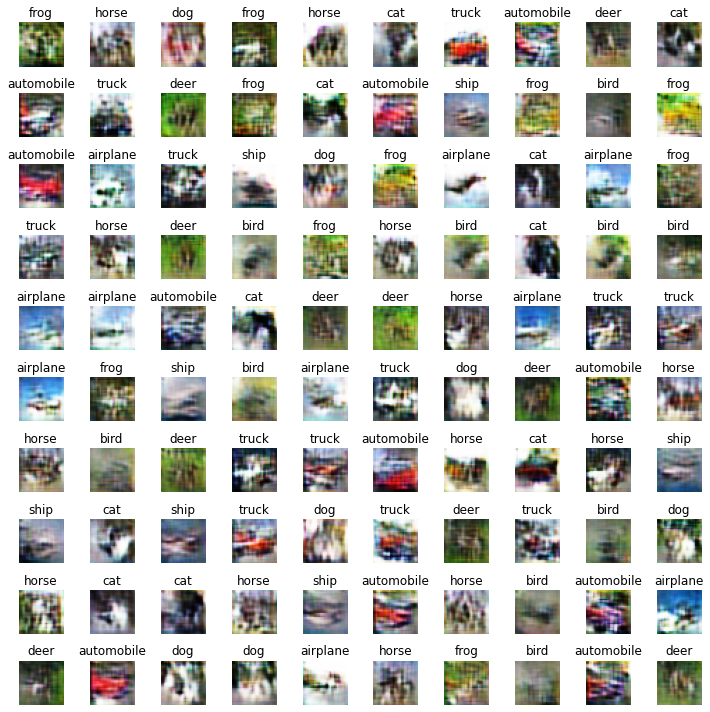

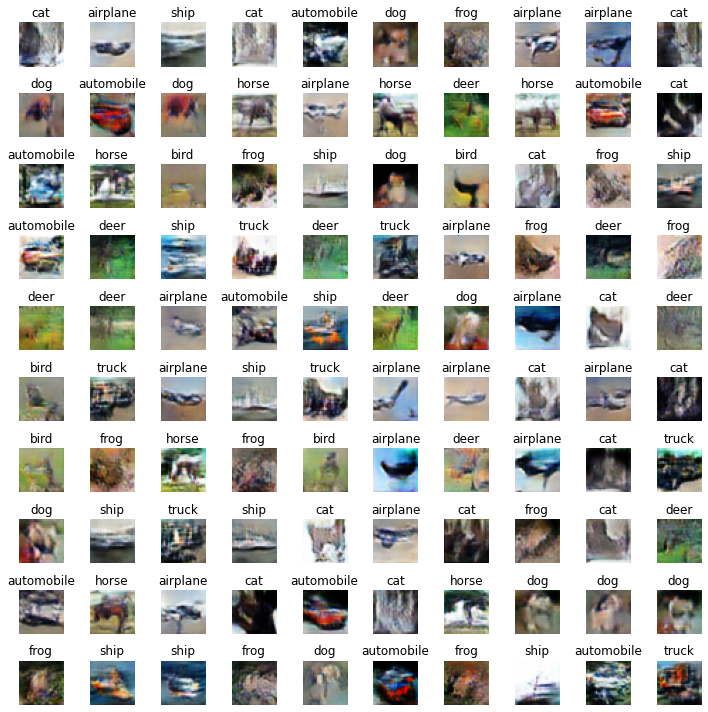

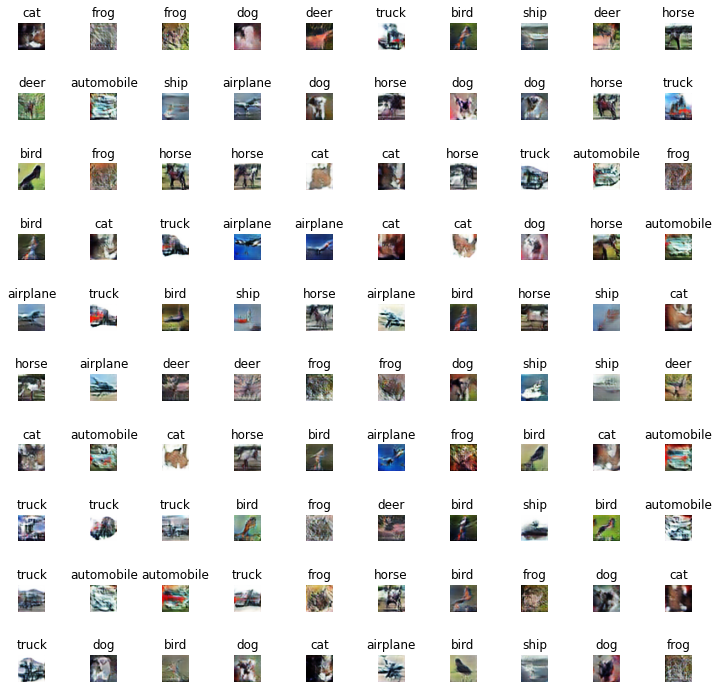

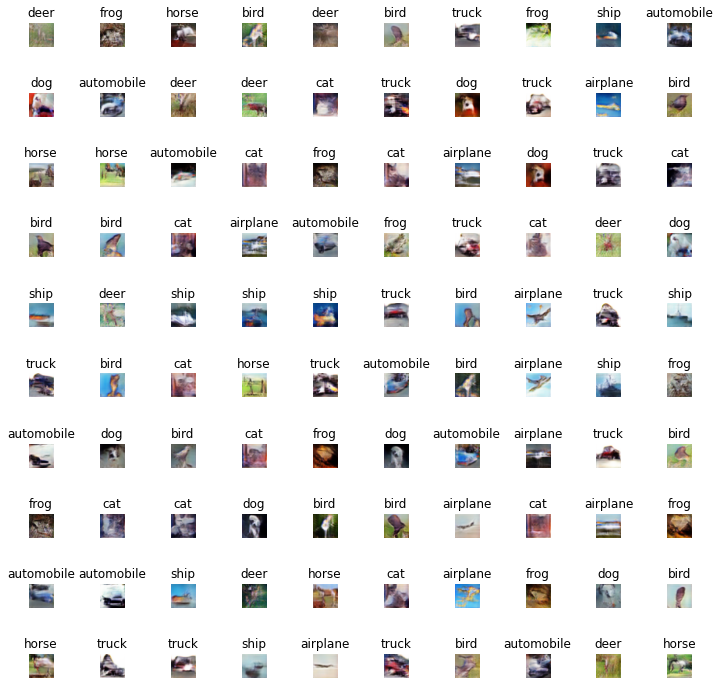

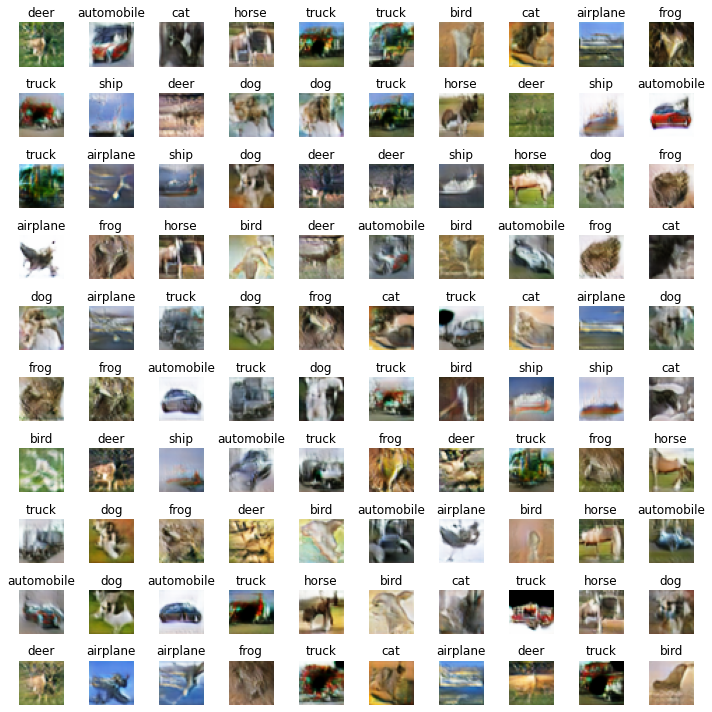

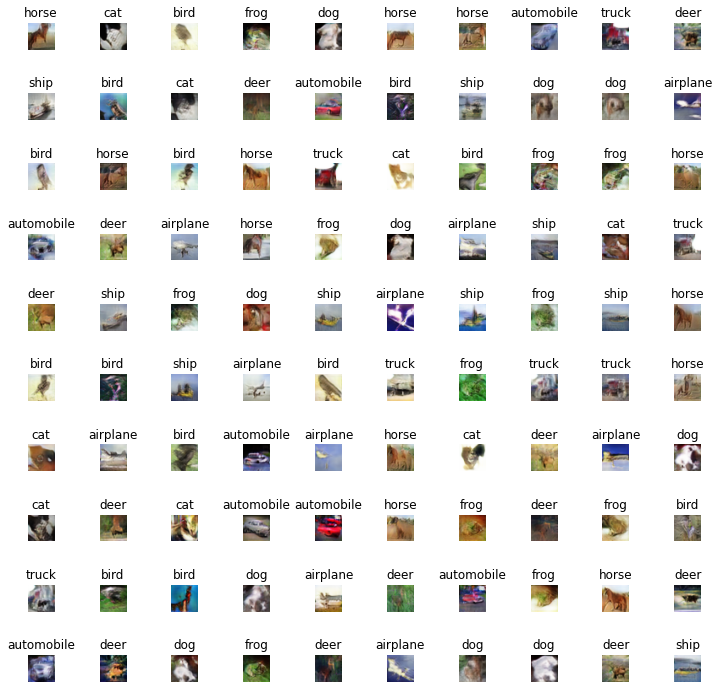

In [32]:
#Training cell for number of epochs
for i in range(26):
  #Train one batch of mages
    train_batch(epoch,data_loader,generator,discriminator, d_hinge, g_hinge,aux_loss,g_optimizer,d_optimizer,device,**hparams)
    
    #Learning rate scheduler every 5 epochs
    g_scheduler.step()
    d_optimizer.step()
    if epoch % 5 == 0:
        #Evaluate FID Score and IS Score every 5 epochs
        evaluate(epoch, generator, concat_data, **hparams)
        #Run the save generated images function to save every 5 images
        save_gen_imgs(epoch=epoch,base_folder="generated-image",generator=generator,image_num=1000,n_classes=10,latent_dim=100,
        classname_mapping = cifar10_classnames,device=device,inv_preprocessing=partial(inverseNormalize, mean=normalize_mean_std, std=normalize_mean_std))

    epoch += 1

In [33]:
wandb.finish()

AuxAcc,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
DiscLoss,█▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
FID_score,█▂▂▁▁▁
GenLoss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
IS_score,▁▅▆▇██
epoch,▁▁▂▄▅▇█
AuxAcc,88.05554
DiscLoss,2.62166
FID_score,51.51873
GenLoss,0.47296
IS_score,6.74428


In [34]:
!zip -r /content/generated-image/25.zip /content/generated-image/25

  adding: content/generated-image/25/ (stored 0%)
  adding: content/generated-image/25/airplane/ (stored 0%)
  adding: content/generated-image/25/airplane/89.png (stored 0%)
  adding: content/generated-image/25/airplane/49.png (stored 0%)
  adding: content/generated-image/25/airplane/8.png (stored 0%)
  adding: content/generated-image/25/airplane/7.png (stored 0%)
  adding: content/generated-image/25/airplane/22.png (stored 0%)
  adding: content/generated-image/25/airplane/86.png (stored 0%)
  adding: content/generated-image/25/airplane/91.png (stored 0%)
  adding: content/generated-image/25/airplane/76.png (stored 0%)
  adding: content/generated-image/25/airplane/82.png (stored 0%)
  adding: content/generated-image/25/airplane/1.png (stored 0%)
  adding: content/generated-image/25/airplane/83.png (stored 0%)
  adding: content/generated-image/25/airplane/80.png (stored 0%)
  adding: content/generated-image/25/airplane/55.png (stored 0%)
  adding: content/generated-image/25/airplane/75.

In [35]:
from google.colab import files
files.download('/content/generated-image/25.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>